In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [2]:
# Reading meta-data from csv file

df = pd.read_csv('D:/#Abror/skin_diseases/HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Joining two folders, each containing 5 000 images

skin_dir = os.path.join('D:/#Abror/', 'skin_diseases')

path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(skin_dir, '*', '*.jpg'))}

In [5]:
# Creating dictionaries better for understanding of labels 

lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['path'] = df['image_id'].map(path_dict.get)
df['cell_type'] = df['dx'].map(lesion_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,D:/#Abror/skin_diseases\HAM10000_images_part_2...,Benign keratosis-like lesions,2


In [7]:
# Loading and resizing all images. Images can be resized in higher resolution based on machine performance.

df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((32, 32))))

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,D:/#Abror/skin_diseases\HAM10000_images_part_1...,Benign keratosis-like lesions,2,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,D:/#Abror/skin_diseases\HAM10000_images_part_2...,Benign keratosis-like lesions,2,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


Data cleaning

In [9]:
print(df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [10]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
image             0
dtype: int64

In [31]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [32]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
image            0
dtype: int64

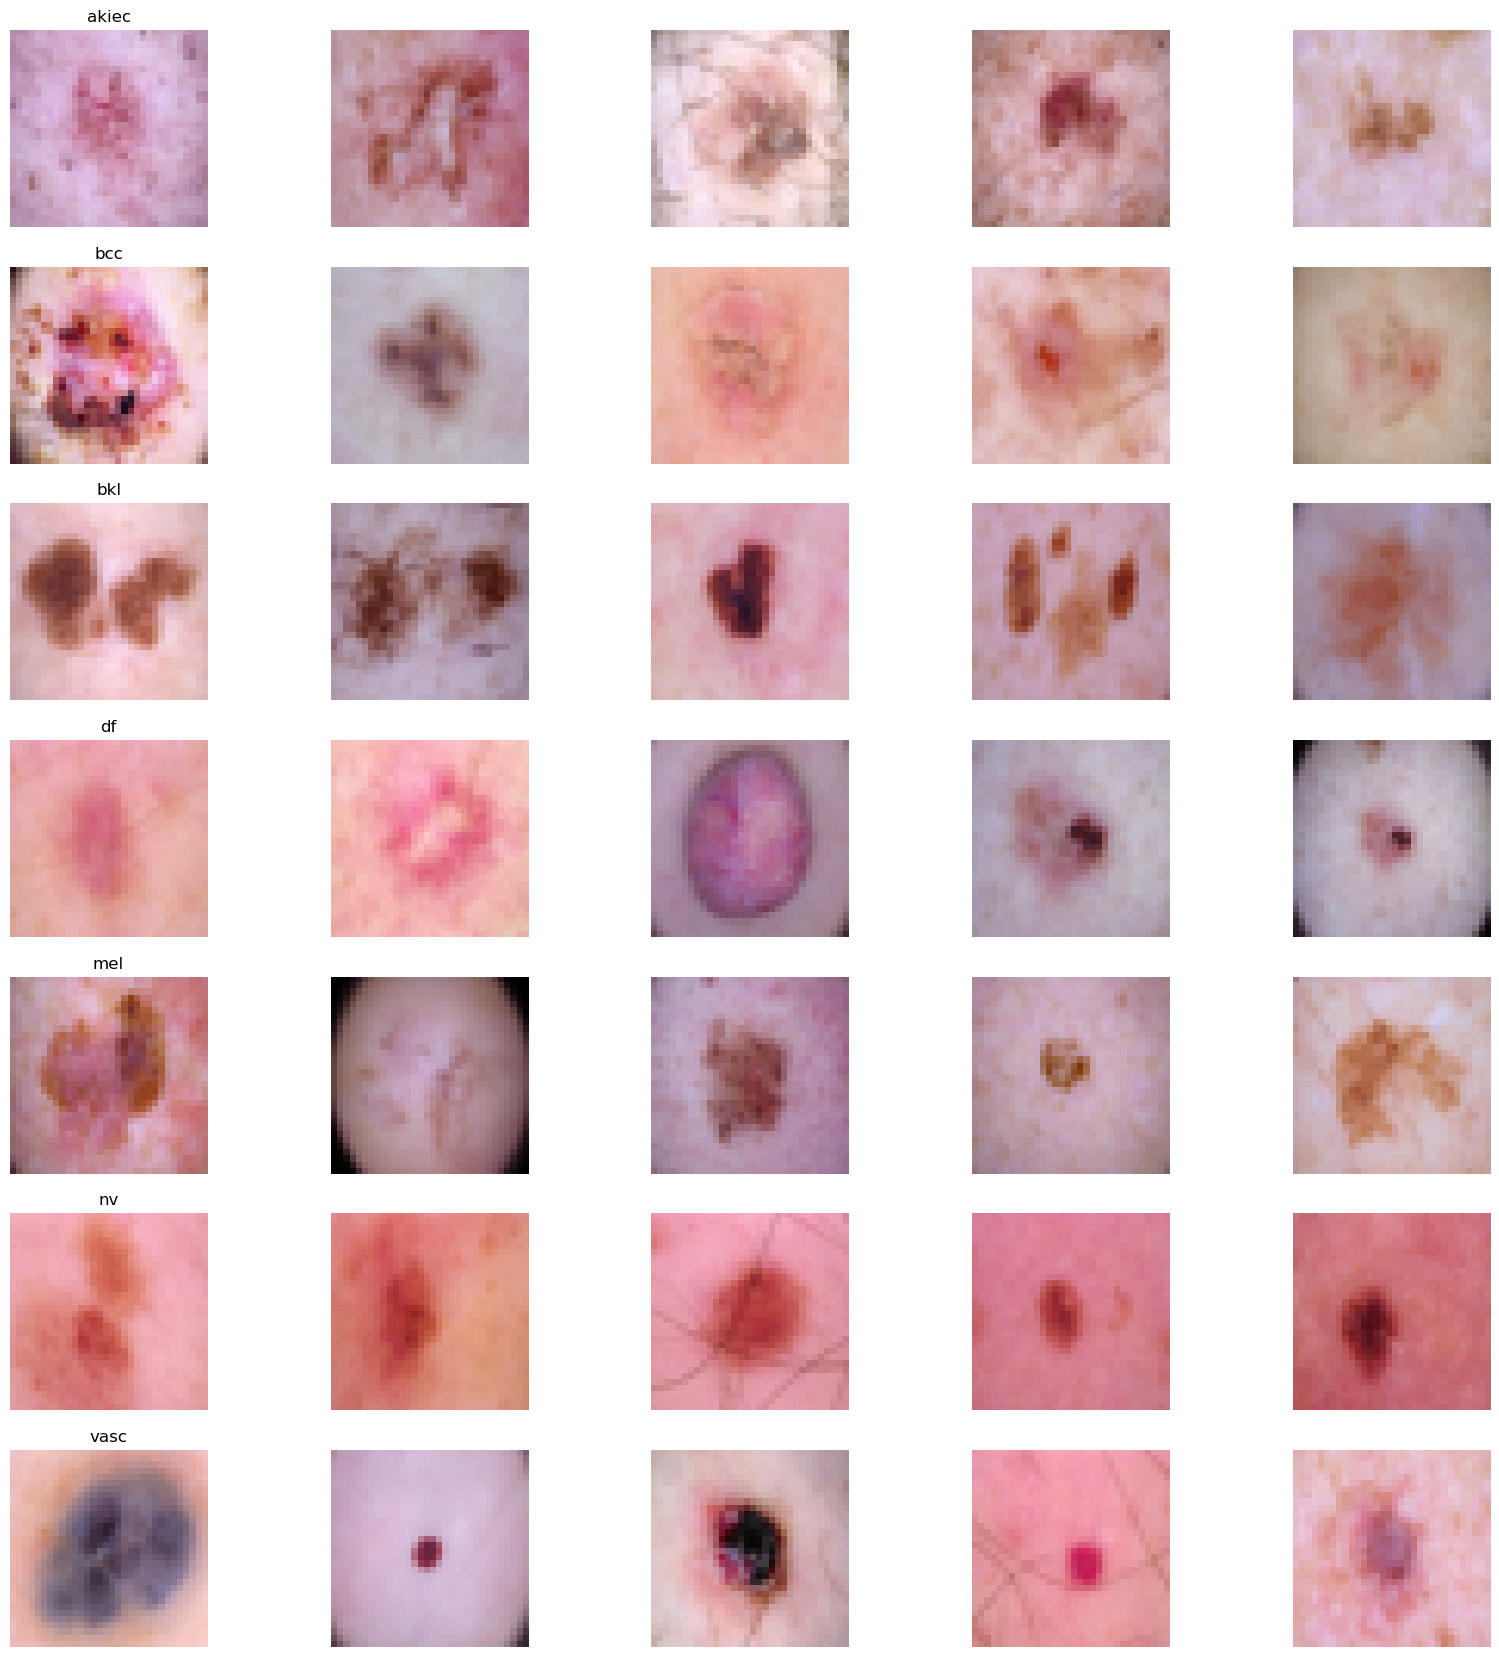

In [11]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1104).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

EDA

<AxesSubplot:>

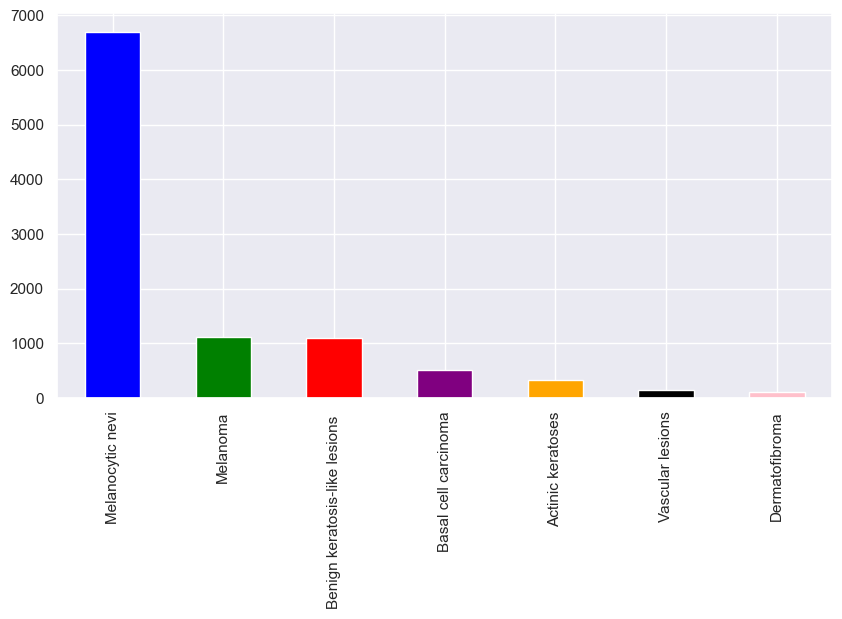

In [95]:
col1 = ['blue', 'green', 'red', 'purple', 'orange', 'black', 'pink', 'yellow', 'grey',]
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=col1)


<AxesSubplot:>

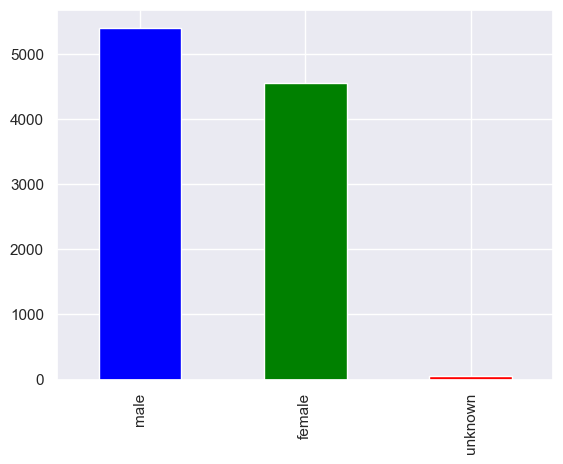

In [99]:
df['sex'].value_counts().plot(kind='bar', color=col1)

<AxesSubplot:>

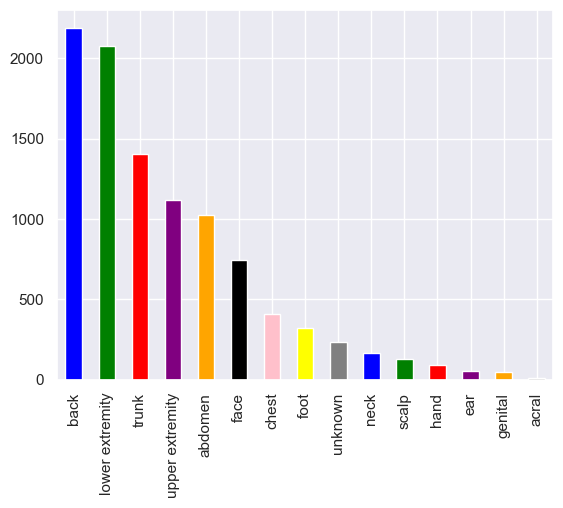

In [102]:
df['localization'].value_counts().plot(kind='bar', color=col1)

<AxesSubplot:>

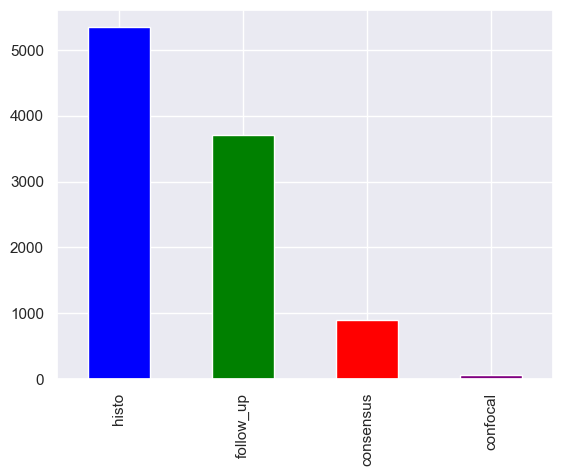

In [104]:
df['dx_type'].value_counts().plot(kind='bar', color=col1)

(array([  39.,   86.,   41.,   77.,  169.,  247.,    0.,  464.,  753.,
         985., 1299., 1187., 1066.,    0.,  803.,  731.,  756.,  618.,
         404.,  290.]),
 array([ 0.  ,  4.25,  8.5 , 12.75, 17.  , 21.25, 25.5 , 29.75, 34.  ,
        38.25, 42.5 , 46.75, 51.  , 55.25, 59.5 , 63.75, 68.  , 72.25,
        76.5 , 80.75, 85.  ]),
 <BarContainer object of 20 artists>)

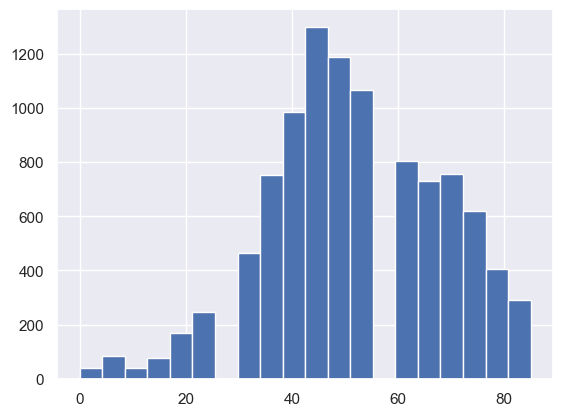

In [108]:
plt.hist(df['age'], bins=20)

In [12]:
#Normalization
x = np.asarray(df['image'].tolist())

In [13]:
x = x.astype('float32') / 255

In [14]:
y = df['cell_type_idx'] 

In [15]:
#One-hot encoding
y_categorical = to_categorical(y, num_classes=7)

In [16]:
#Split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y_categorical, test_size=0.20, random_state=1104)

In [42]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 3)

In [38]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

Model Building

In [17]:
num_classes = 7

cnn = Sequential()
cnn.add(Conv2D(256, (3, 3), activation="relu", input_shape=(32, 32, 3)))
cnn.add(MaxPool2D(pool_size=(2, 2)))  
cnn.add(Dropout(0.3))

cnn.add(Conv2D(128, (3, 3),activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))  
cnn.add(Dropout(0.3))

cnn.add(Conv2D(64, (3, 3),activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))  
cnn.add(Dropout(0.3))
cnn.add(Flatten())

cnn.add(Dense(32))
cnn.add(Dense(7, activation='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

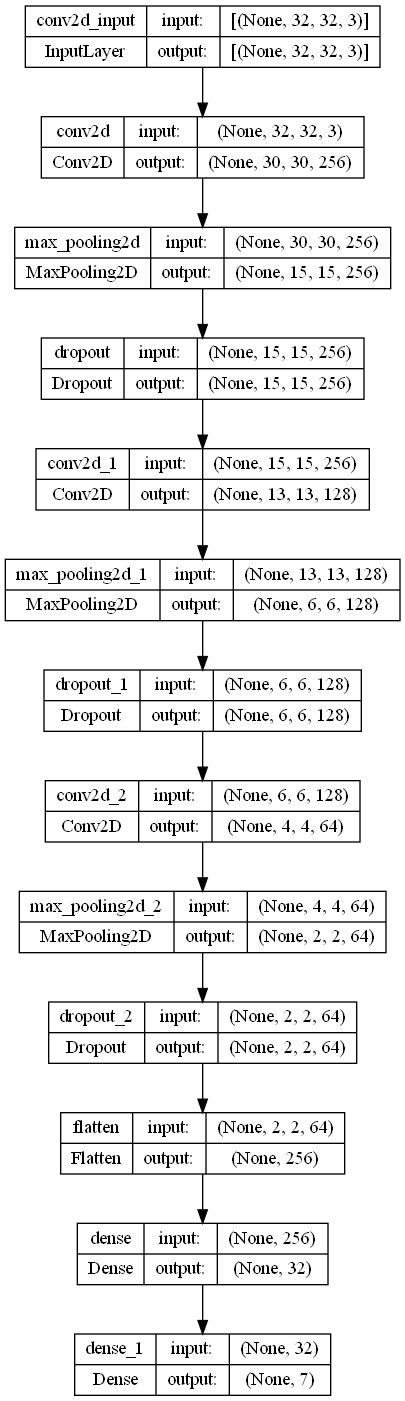

In [18]:
plot_model(cnn, to_file='convnet.png', show_shapes=True, show_layer_names=True)

In [19]:
cnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [20]:
#Learning rate reduction

learning_rate_red = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
# Fitting the model

batch_size = 10
epochs = 50

history = cnn.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=1, callbacks=[learning_rate_red])

Epoch 1/50
802/802 [==============================] - 32s 39ms/step - loss: 1.0122 - acc: 0.6706 - val_loss: 0.9532 - val_acc: 0.6765 - lr: 0.0010
Epoch 2/50
802/802 [==============================] - 30s 38ms/step - loss: 0.9412 - acc: 0.6752 - val_loss: 0.8924 - val_acc: 0.6830 - lr: 0.0010
Epoch 3/50
802/802 [==============================] - 31s 39ms/step - loss: 0.9100 - acc: 0.6794 - val_loss: 0.8880 - val_acc: 0.6760 - lr: 0.0010
Epoch 4/50
802/802 [==============================] - 31s 38ms/step - loss: 0.8718 - acc: 0.6866 - val_loss: 0.8128 - val_acc: 0.6925 - lr: 0.0010
Epoch 5/50
802/802 [==============================] - 31s 39ms/step - loss: 0.8497 - acc: 0.6952 - val_loss: 0.7958 - val_acc: 0.7129 - lr: 0.0010
Epoch 6/50
802/802 [==============================] - 31s 39ms/step - loss: 0.8286 - acc: 0.6980 - val_loss: 0.7760 - val_acc: 0.7084 - lr: 0.0010
Epoch 7/50
802/802 [==============================] - 31s 38ms/step - loss: 0.8095 - acc: 0.7056 - val_loss: 0.7853 - 

In [47]:
# Model evaluation

score = cnn.evaluate(x_test, y_test)
val_acc = cnn.evaluate(x_validate, y_validate)
print("Validation: accuracy = %f  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  loss = %f" % (accuracy, loss))

26/26 [==============================] - 1s 27ms/step - loss: 0.5036 - acc: 0.8242
Validation: accuracy = 0.824190  loss_v = 0.503587
Test: accuracy = 0.757364  loss = 0.621529


Text(0, 0.5, 'Incorrect predictions')

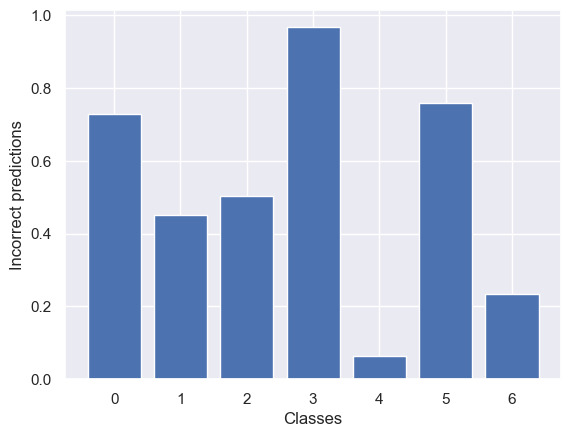

In [88]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('Classes')
plt.ylabel('Incorrect predictions')

Conclusion - 
Overall, the model got pretty high accuracy, 75%. It can be improved up to 80 – 90% by applying additional techniques such as data augmentation or data balancing, because the dataset is heavily imbalanced. Other methods can include adjusting hyperparameters or layers of the model.